# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Transfer learning

In the previous notebook I have trained my own CNN and we got a certain performance. Now I am checking how hard it is to match that performance with transfer learning.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up


In [1]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

#!pip install -r requirements.txt


  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached bokeh-3.4.2-py3-none-any.whl.metadata (12 kB)
  Using cached livelossplot-0.5.5-py3-none-any.whl.metadata (8.7 kB)
  Using cached pytest-8.2.2-py3-none-any.whl.metadata (7.6 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached xyzservices-2024.6.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached iniconfig-2.0.0-py3-none-any.whl.metadata (2.6 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.9 MB)
Using cached bokeh-3.4.2-py3-none-any.whl (7.0 MB)
Using cached livelossplot-0.5.5-py3-none-any.whl (22 kB)
Using cached pytest-8.2.2-py3-none-any.whl (339 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached xyzservices-2024.6.0-py3-none-any.whl (83 kB)
Using cached iniconfig-2.0.0-py3-none-any.whl (5.9 kB)


In [2]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU *NOT* available. Will use CPU (slow)
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


In [6]:
!python --version

Python 3.10.14


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 1: Create transfer learning architecture

Opened the file `src/transfer.py` and completed the `get_model_transfer_learning` function. Once I was done, I executed this test:

In [3]:
!pytest -vv src/transfer.py

============================= test session starts ==============================
platform linux -- Python 3.10.14, pytest-8.2.2, pluggy-1.5.0 -- /opt/conda/envs/sagemaker-distribution/bin/python3.1
cachedir: .pytest_cache
rootdir: /home/studio-lab-user/sagemaker-studiolab-notebooks/Project_3_ML_Engineer/unzipped_files
plugins: anyio-4.3.0, dash-2.17.0
collected 1 item                                                               

src/transfer.py::test_get_model_transfer_learning PASSED                 [100%]

=============================== warnings summary ===============================
src/transfer.py::test_get_model_transfer_learning
  /opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
    warnings.warn(

src/transfer.py::test_get_model_transfer_learning
  /opt/conda/envs/sagemaker-distribution/lib/pytho

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Train, validation and test

Here I am training my transfer learning model. I started by defining the hyperparameters:

In [12]:
batch_size = 128
valid_size = 0.2
num_epochs = 100
num_classes = 50
dropout = 0.3
learning_rate = 0.0001
opt = 'adam'
weight_decay = 0.0004

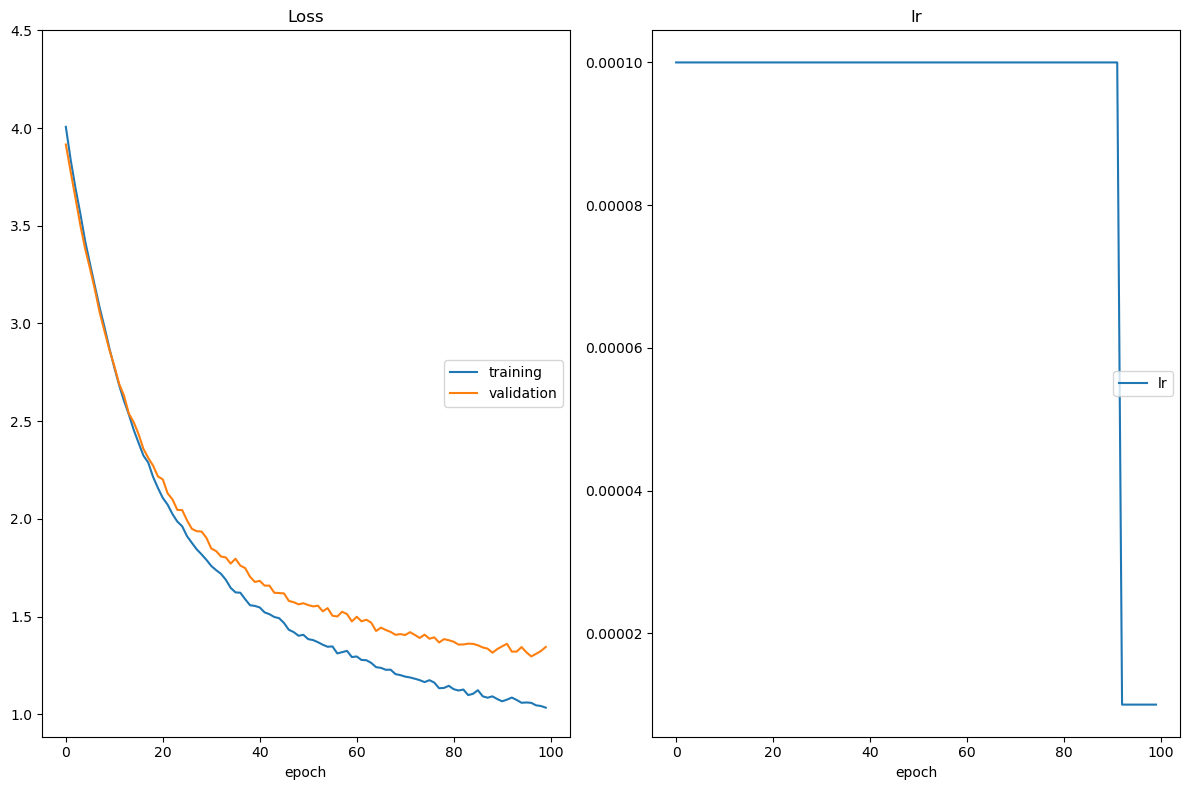

In [ ]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning

# Get a model using get_model_transfer_learning.
model_transfer = get_model_transfer_learning(model_name="resnet18", n_classes=50)

# Train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True
)


<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> __Question:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

Answer:
My architecture uses a pre-trained model. I chose resnet18 as it leverages learned features from a large dataset, making it highly effective for transfer learning. By freezing the pre-trained layers,when retraining I reduced training complexity, preventing overfitting. The final fully connected layer was modified to match the specific number of target classes (50), giving the model a chance to adapt to the current issue. This approach balances complexity and computational efficiency, ensuring robust performance for the image classification task.



---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: Testing the Model

Tried out my model on the test dataset of landmark images. 

In [16]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("resnet18", n_classes=num_classes)
# Load saved weights
model_transfer.load_state_dict(torch.load('checkpoints/model_transfer.pt'))

one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 10/10 [00:08<00:00,  1.14it/s]

Test Loss: 1.098242


Test Accuracy: 72.64% (908.0/1250.0)


1.0982421815395353

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Exported using torchscript

Just like with my original model, I exported the best fit model using torchscript so that it can be used in my application:

In [17]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model_transfer = model_transfer.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer.pt", map_location="cpu")
)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

Reusing cached mean and std


  0%|                                          | 1/1250 [00:00<04:46,  4.35it/s]/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() profile_node %388 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1698976205261/work/third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  return forward_call(*args, **kwargs)
code/__torch__/torchvision/transforms/functional.py:188: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will stil

Accuracy: 0.7272


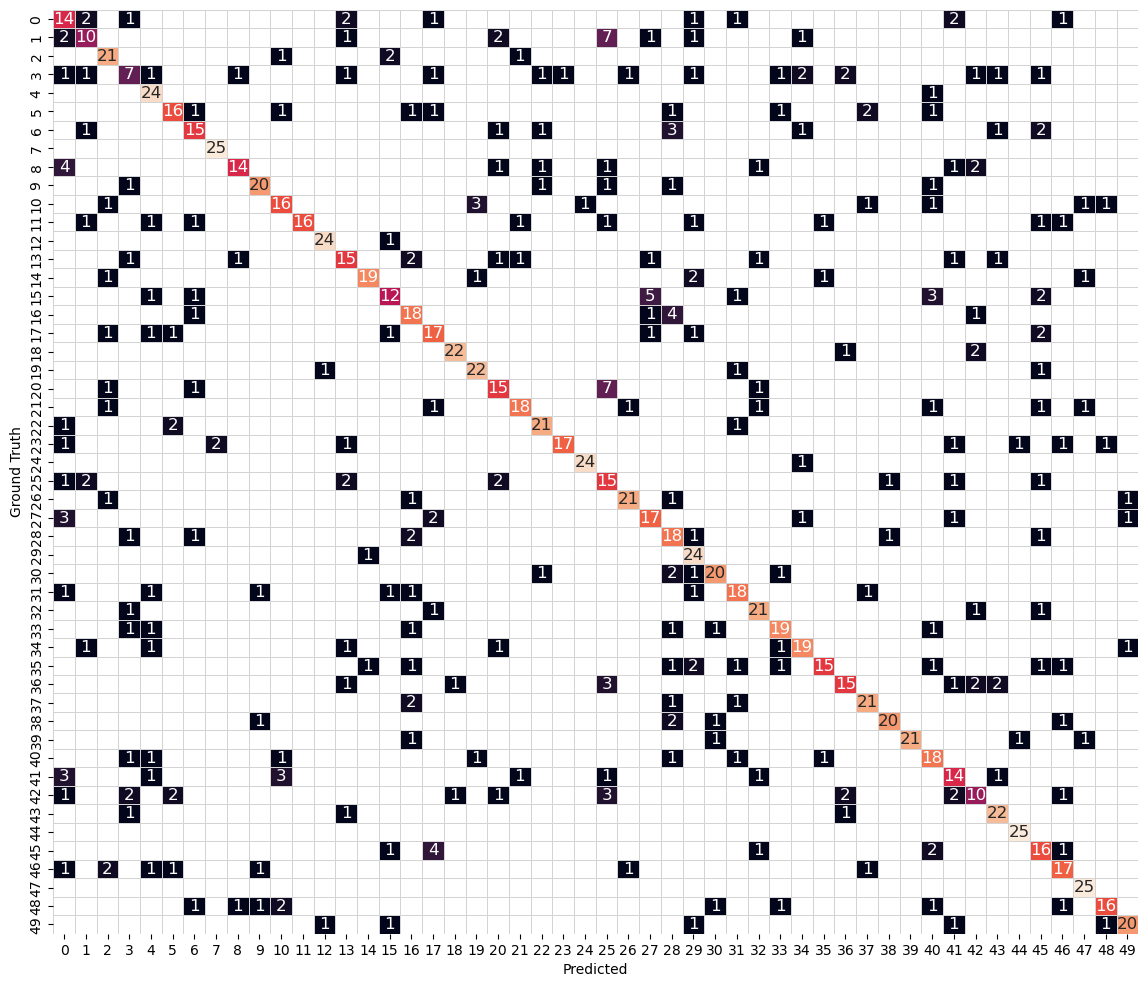

In [18]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

plot_confusion_matrix(pred, truth)